## Zbiór danych MNIST
Zbiór danych MNIST składa się z 70 000 małych rysunków zawierających cyfry odręcznie zapisane przez uczniów szkół średnich i pracowników amerykańskiego Biura Spisu Ludności. Każdy rysunek zawiera etykietę określającą zawartą na nim cyfrę.

Zestaw danych MNIST pobieramy za pomocą modułu Scikit-Learn:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Zazwyczaj zbiory danych wczytywane przez moduł Scikit-Learn mają podobne strukturę składającą się z następujących elementów:
- klucza `DESCR` opisującego zbiór danych,
- klucza `data` zawierającego tablicę, w której każdy wiersz reprezentuje przykład, a kolumna – cechę,
- klucza `target` przechowującego tablicę etykiet.

Spójrzmy na tablicę:

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
28 * 28

784

W tym zbiorze danych występuje 70 000 obrazów, a każdy z nich jest opisany 784 cechami. Każdy obraz ma rozmiar 28x28 pikseli i każda cecha opisuje natężenie szarości danego piksela i przyjmuje wartości od 0 (kolor biały) do 255 (kolor czarny). Aby sprawdzić jak wygląda przykładowa cyfra przechowywana w zestawie danych, wystarczy w tym celu wybrać wektor cech danej  próbki i przekształcić go w macierz o rozmiarze 28x28, a następnie wyświetlić go za pomocą funckji `imshow()` w module Matplotlib:

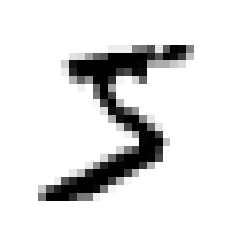

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

Obrazek ten przypomina liczbę "5". Gdy spróbujemy wywołać etykietę, faktycznie tak jest:

In [6]:
y[0]

'5'

Etykieta jest łańcuchem znaków. Większość algorytmów uczenia maszynowego spodziewa się wartości numerycznych, dlatego przekształćmy `y` w liczbę całkowitą:

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# BONUS
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

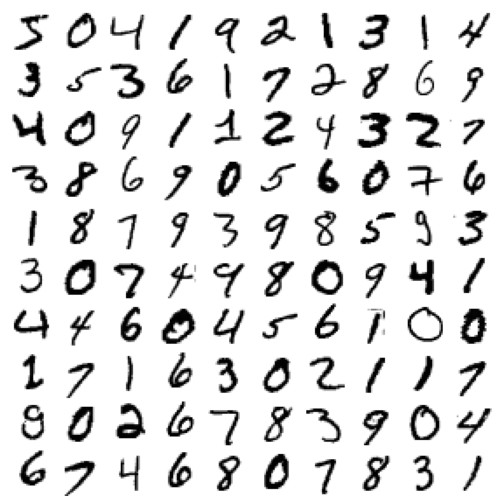

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

Przed dokładniejszym przyjrzeniem się danych powinniśmy zawsze najpierw stworzyć zbiór testowy i odstawić go na bok. Zestaw MNIST jest już podzielony na zbiory uczący (piersze 60 000 przykładów) i testowy (pozostałe 10 000 obrazów):

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Zestaw danych uczących został już za nas przetasowany, co jest dobry rozwiązaniem, gdyż gwarantuje, że podzbiory utworzone podczas sprawdzianu krzyżowego będą do siebie podobne (nie chcemy, aby w którymś podzbiorze zabrakło jakiejś cyfry). Ponadto niektóre algorytmy są wrażliwe na kolejność próbek uczących i nie za dobrze sobie z tym radzą, jeżeli przetwarzają wiele podobnych przykładów z rzędu. Unikamy ten problem przy przetasowaniu zbioru danych (**ALE** to nie jest uniwersalne rozwiązanie, nie działa to dobrze z danymi szeregu czasowego [**giełda**]).

## Uczenie klasyfikatora binarnego
Uprośćmy na razie problem i spróbujmy identyfikować tylko jedną cyfrę np. 5. Ten "wykrywacz piątek" będzie stanowił przykład **klasyfikatora binarnego** (*binary classifier*), zdolnego do rozpoznawania jedynie dwóch klas: **piątek** i **niepiątek**. Stwórzmy wektory docelowe dla tego zadania klasyfikującego:

In [12]:
y_train_5 = (y_train == 5) # Wartość True dla piątek, False dla wszystkich pozostałych cyfr
y_test_5 = (y_test == 5)

Teraz wybierzmy i wytrenujmy jakiś klasyfikator. Warto rozpocząć od klasyfikatora **stochastycznego spadku wzdłuż gradientu** (*Stochastic Gradient Descent* – SGD) – posłuży nam do tego klasa `SGDClassifier`. Algorytmy ten cechuje się możliwością wydajnego przetwarzania bardzo dużych zestawów danych, gdyż klasyfikator SGD przetwarza poszczególne przykłady uczące niezależnie od siebie, po jednym naraz (z tego powodu nadaje się on również do **uczenia przyrostowego**)

Stwórzmy klasyfikator `SGDClassifier` i wytrenujmy go wobec całego zbiory uczącego:

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

🟢🟢 Skuteczność klasyfikatora `SGDClassifier` zależy od losowości na etapie uczenia (stąd przymiotnik *stochastyczny*). Jeśli chcesz, aby wyniki były powtarzalne, wyznacz wartość parametru `random_state`. 🟢🟢

Możemy teraz posłużyć się tym algorytmem do wykrywania cyfry "5" w zbiorze danych:

In [14]:
sgd_clf.predict([some_digit])

array([ True])

Klasyfikator zgaduje, ze na wyznaczonym obrazie znajduje się cyfra 5 (wartość `True`). Wygląda na to, że się nie pomylił w tym konkretnym przypadku!

Teraz należy ocenić wydajność tego modelu

## Miary wydajności


Często ocena klasyfikatora stanowi większe wyzwanie od ewaluacji regresoa, daltego poświęcimy temu zagadanieniu dużą część niniejszego rozdziału. Istnieje wiele miar wydajności, przed nami kolejna dawka nowych pojęć i skoków!

### Pomiar dokładności za pomocą sprawdzianu krzyżowego
Zastosowanie metody sprawdzianu krzyżowego jest dobrym sposobem oceny modelu.

Wykorzystujemy funkcję `cross_val_score()` do oceny naszego modelu `SDGClassifier` za pomocą metody sprawdzianu krzyżowego; wygenerujemy trzy podzbiory.

Przypominam: **kroswalidacja k-ktorna** oznacza rozdzielenie zestawu uczącego na k podzbiorów (w tym przypadku k=3), następnie wyuczenie modelu k-1 podzbiorach, a na końcu przeprowadzenie prognoz i ich ocena wobec ostatniego podzbioru, a wszystko powtórzone k razy, tak że zostają wykorzystane wszystkie podzbiory:

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Sukces! **Dokładność** powyżej 85% (współczynnik prawidłowych prognoz) wobec wszystkich podzbiorów sprawdzianu krzyżowego 😱❗️

Przyjrzyjmy się bardzo prostemy klasyfikatorowi klasyfikującemy jedynie obrazy niebędące piątkami:

### Implementacja sprawdzianu krzyżowego
Czasem bedziemy potrzebować większej kontroli nad metodą kroswalidacji, niż zapewnia nam domyślnie moduł Scikit-Learn. W takim przypadku możemy samodzielnie zaimplementować sprawdzian krzyżowy. Poniższy kod wykonume mniej więcej te same operacje, co funkcja `cross_val_score()` i wyświetla te wyniki:

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # Wyświetla wyniki

/Users/maurycyczajka/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


Klasa `StratifiedKFold` przeprowadza losowanie warstwowe, dzięki któremu otrzymujemy podzbiory zawierające reprezentacje populacji każdej z klas. W każdym przebiegu kod tworzy klon klasyfikatora, trenuje go za pomocą podzbiorów uczących i ocenia zdolności prognostyczną na podzbiorze testowym. Następnie jest zliczana liczba prawidłowych prognoz i zostaje wyświetlony współczynnik prawidłowych prognoz.

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Sprawdźmy, jak będzie wyglądać dokładność modelu:

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

**Dokładność rzędu 90%!!** Wynika to jednak z faktu, że tylko około 10% wszystkich obrazów stanowią piatki, dlatego gdybyśmy zawsze zgadywali, że dany obraz nie jest piątką, to mielibyśmy rację w ok. 90% przypadków.

Teraz już wiemy, dlaczego generalnie dokładność nie stanowi dobrej miary wydajności klasyfikatorów, zwłaszcza w przypadku **wypaczonych zbiorów danych** (*skewed datasets*, są to takie zbiory danych, w których niektóre klasy występują znacznie częściej od pozostałych).

### Macierz pomyłek
Znacznie lepszym sposobem oceny wydajności klasyfikatora jest analiza **macierzy pomyłek** (*confusion matrix*). Koncepcja polega na zliczaniu przypadków zaklasyfikowania próbek z klasy A jako przykładów należących do klasy B. Przykładowo, aby dowiedzieć się ile razy algorytm pomylił obrazy piątek z obrazami trójek, wystarczy spojrzeć na piąty rząd i trzecią kolumnę macierzy pomyłek.

W celu obliczenia macierzy pomyłek musimy najpierw uzyskać zbiór prognoz, które porównamy z rzeczywistymi wartościami docelowymi. Moglibyśmy prognozować wyniki dla zbioru testowego, jednak na razie nie będziemy go ruszać (pamiętaj, że chcemy wykorzystać zestaw testowy jedynie na samym końcu projektu, gdy nasz klasyfikator będzie już gotowy do pracy). Zamiast tego skorzystamy z funkcji `cross_val_predict()`:

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Funkcje `cross_val_score()` i `corss_val_predict()`, przeprowadzają k-krotny sprawdzian krzyżowy, jednak ta druga nie zwraca wyników ewaluacji, lecz prognozy uzyskane dla każdego podzbioru testowego. Oznacza to, że mozemy otrzymać 'czystą' prognoże dla każdej próbki stanowiącej część zbioru uczącego ("czysta" oznacza w tym kontekście, że prognoza została uzyskana przez model, który wcześniej nie widział tego przykładu na etapie uczenia).

Teraz możemy uzyskać macierz pomyłek za pomocą funkcji `confusion_matrix()`. Wystarczy podać klasy docelowe `(y_train_5)` i przewidywane klasy `(y_train_pred)`:

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

Macierz pomyłek wskazuje wiele informacji, jednakże czasem potrzebny jest bardziej zwięzły wskaźnik. Takim jest dokładność pozytywnych prognoz – jest to tak zwana **precyzja klasyfikatora**.

**Równanie 3.1.** *Precyzja*
### $$ Precyzja = \frac{PP}{PP + FP} $$

Najbardziej banalnym sposobem uzyskania doskonałej precyzji kest otrzymanie pojedynczej pozytywnej prognozy i upewnienie się, że jest prawidłowa (Precyzja = 1/1 = 100%). Nie byłoby to jednak przydatne, bo klasyfikator ignorowałby wszystkie próbki oprócz jednej pozytywnej. Precyzję należy używać wraz z innym wskaźnikiem, zwanym **pełnością**, **czułością** lub **odsetkiem prawdziwie pozytywnych** (OPP): jest to odsetek pozytywnych przykładów, które zostały prawidłowo rozpoznane przez klasyfikator.

**Równanie 3.2.** *Pełność*
### $$ Pełność = \frac{PP}{PP + FN} $$
***

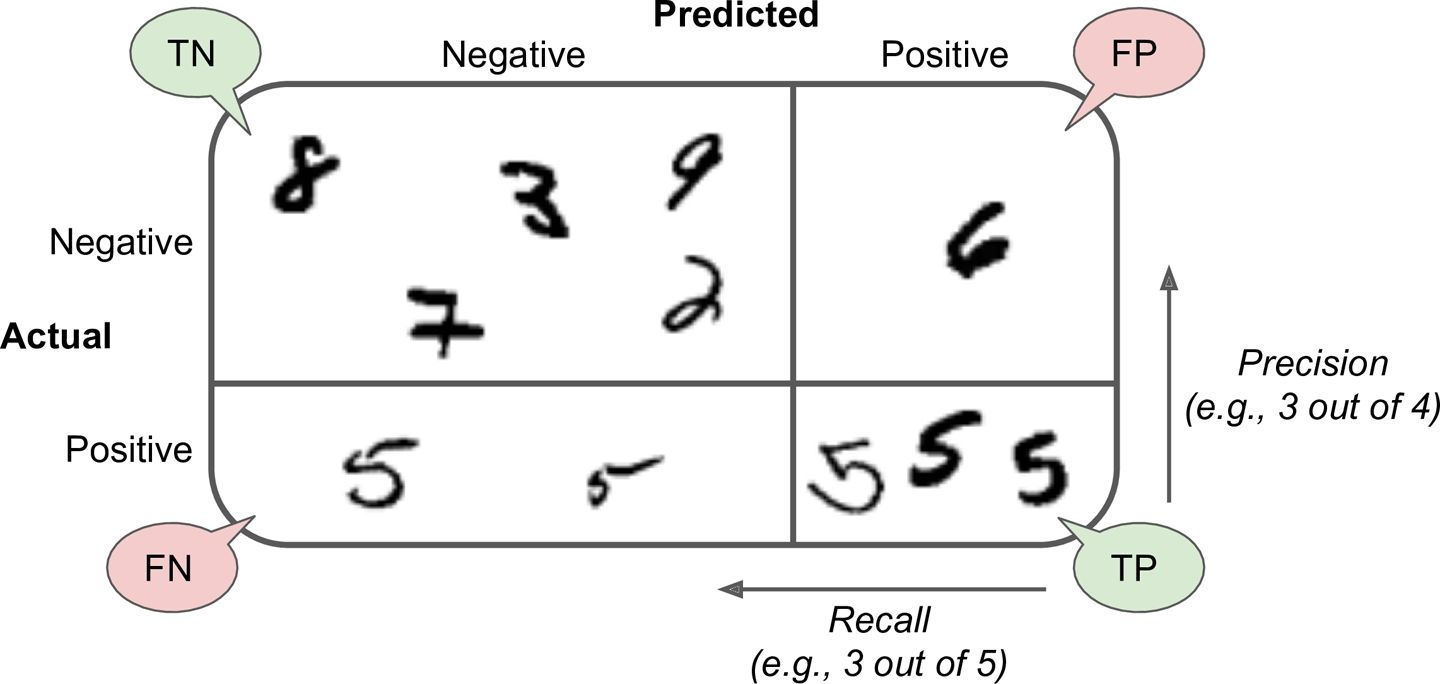

**Rysunek 3.2** *Schemat macierzy pomyłek ukazujący przykłady prawdziwie negatywne (lewy górny róg), fałszywie pozytywne (prawy górny róg), fałszywie negatywne (lewy dolny róg) i prawdziwie pozytywne (prawy dolny róg).*

### Precyzja i pełność
Moduł Scikit-Learn zawiera kilka funkcji obliczających wskaźniki klasyfikatorów, w tym również precyzję i pełność:

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [22]:
recall_score(y_train_5, y_train_pred)

0.8310274857037447

Wykrywacz piątek nie jest już tak imponujący jak na etapie sprawdzania jego dokładności. Gdy uznaje, że rozpoznaje "5", nie myli się jedynie w 75% przypadków, a do tego rozpoznaje jedynie 83% piątek.

Aby połączyć precyzję i pełność oraz porównać dwa klasyfikatory, można użyć **wynik $F_{1}$** – stanowi on **średnią harmoniczną** precyzji i pełności. Standardowa średnia traktuje wszystkie wartości jednakowo, natomiast średnia harmoniczna nadaje większą wagę małym wartościom. W rezultacie klasyfikator uzyska dużą wartość wyniku $F_{1}$ jedynie wtedy, gdy zarówno precyzja, jak i pełność będą miały dużą wartość.

**Równanie 3.3.** *Wynik $F_{1}$*
$$
F_1 = \cfrac{2}{\cfrac{1}{\text{precyzja}} + \cfrac{1}{\text{pełność}}} = 2 \times \cfrac{\text{precyzja}\, \times \, \text{pełność}}{\text{precyzja}\, + \, \text{pełność}} = \cfrac{PP}{PP + \cfrac{FN + FP}{2}}
$$

Aby obliczyć $F_{1}$, wystarczy wywołać funkcję `f1_score()`:

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.791044776119403

Wynik $F_{1}$ faworyzuje klasyfikatory mające zbliżone wartości precyzji i pełności, ale nie zawsze tego chcemy: czasem zależy nam na precyzji, czasem na pełności. Przykładowo, po wyuczeniu klasyfikatora w określaniu filmów bezpiecznych dla dzieci, prawdopodobnie dużo dobrych filmów zostałoby odrzuconych (mała wartość pełności), ale zapamiętujący jedynie bezpieczne (duża precyzja). Niekorzystna byłaby sytuacja, w której model cechuje się znacznie większą pełnością, ale jednocześnie dopuszcza kilka nieodpowiednich filmów (w takich przypadkach należy dodać element ludzki do potoku – osobę sprawdzającą wyniki klasyfikatora). Z drugiej strony, załóżmy, że trenujemy klasyfikator rozpoznający złodzei z zapisów kamer: nic się złego nie stanie, jeśli model będzie miał tylko 30% precyzji przy 99% pełności (ochroniarz może wygenerować kilka fałszywych alarmów, ale niemal wszyscy przestępcy zostaną złapani).

Jednakże, wraz ze wzrotemm precyzji maleje pełność i odwrotnie. Zależność ta jest nazywana **kompromisem pomiędzy precyzją a pełnością**.

### Kompromis pomiędzy precyzją a pełnością
Należy zrozumieć w jaki sposób klasyfikator `SGDCClassifer` podejmuje decyzje:
- dla każdej próbki zostaje wyliczony wynik na podstawie **funkcji decyzyjnej**
- jeżeli jego wartość przekroczy określony próg, przykład ten zostnaie przydzielony do klasy pozytywnej, w przeciwnym wypadku będzie wyznaczony do klasy negatywnej

Na **Rysunku 3.3.** widzimy kilka cyfr umieszczonych w kolejności od najniższego do najwyższego wyniku. Załóżmy, że **próg decyzyjny** znajduje się w miejscu wskazywanym przez środkową strzałkę (między dwiema "5"); w ten sposób otrzymujemy po prawej stronie 4 próbki prawdziwie pozytywne (rzeczywiste piątki) i jedną fałszywie pozytywną (cyfra 6). Wówczas, próg precyzji wynosi 80% (cztery z pięciu). Jednak na sześć dostępnych piątek zostają rozpoznane tylko cztery, datego uzyskujemy tu pełność na poziomie 67%  (cztery z sześciu). Jeśli podniesiemy próg (przesuniemy go w prawo), przykład fałszywie pozytywny (cyfra 6) stanie się prawdziwie negatywny, dzięki czemu wzrośnie precyzja (do 100% w omawianym przykładzie), ale z kolei jedna wartość prawdziwie pozytywna przekształci się w fałszy- wie negatywną, przez co wartość pełności zmaleje do 50%. Z kolei obniżenie progu (przesunięcie go w lewo) zwiększy pełność przy jednoczesnej redukcji precyzji.

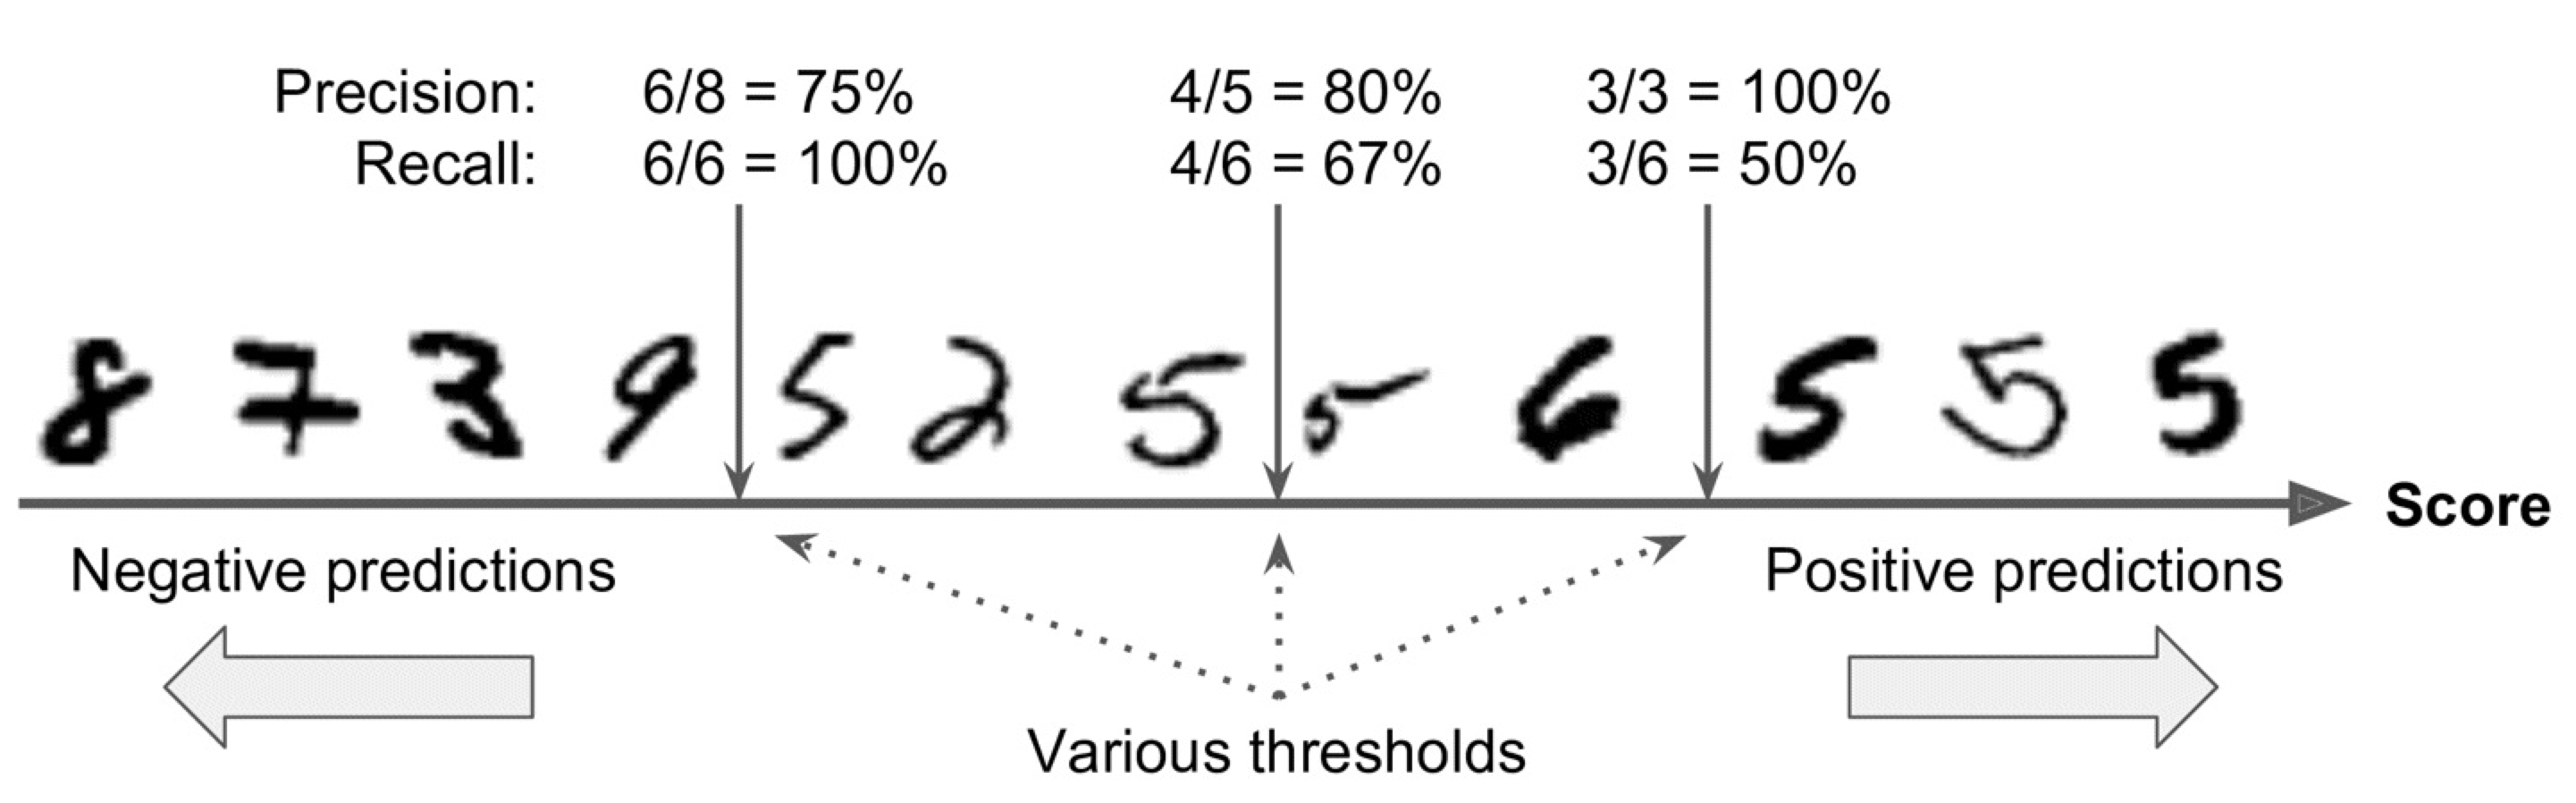

**Rysunek 3.3** *W powyższym kompromisie pomiędzy precyzją a pełnością obrazy są oceniane zgodnie z wynikiem klasyfikatora, a te, których wynik przekroczy wyznaczony próg decyzyjny, zostają uznane za pozytywne; im wyższy próg, tym mniejsza pełność, ale (zazwyczaj) większa precyzja*

Moduł Scikit-Learn nie pozwala na bezpośrednie dobieranie progów, ale daje nam dostęp do wyników decyzyjnych, za pomocą których są wyliczane prognozy. Zamiast wywoływać metodę `predict()`, możemy skorzystać z metody `decision_function()`, która zwraca obliczony wynik dla każdej próbki, a następnie wyliczyć prognozy na podstawie tych wyników przy użyciu dowolnego progu:

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Klasyfikator `SGDClassifier` korzysta z progu o wartości 0, dlatego powyższy kod zwraca taki sam wynik, jak metoda `predict()` (np.`True`). Podnieśmy teraz ten próg:

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Uzyskaliśmy w ten sposób dowód, że podniesienie progu zmniejsza pełność. Analizowany obraz w rzeczywistości symbolizuje cyfrę 5 i klasyfikator rozpoznaje ją przy progu o wartości 0, ale myli się, gdy wartość progu zostanie podniesiona do wartości 8000.

W jaki sposób należy dobierać próg? Najpierw skorzystaj z funkcji `cross_val_predict()`, aby uzyskać wyniki wszystkich przykładów zestawu uczącego, tym razem jednak zaznacz, że chcesz otrzymać nie prognozy, lecz wyniki decyzyjne:

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Mając te wyniki, możesz wyliczyć precyzję i pełność dla wszystkich możliwych progów za pomocą funkcji `precision_recall_curve()`:

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Na koniec za pomocą modułu Matplotlib wygeneruj wykres precyzji i pełności w funkcji progu decyzyjnego (rysunek 3.4):

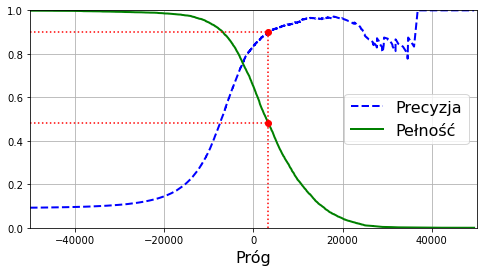

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Próg", fontsize=16)             
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

**Rysunek 3.4.** *Wykres precyzji i pełności w funkcji progu decyzyjnego*

🔵🔵 Pewnie zastanawiasz się, dlaczego na rysunku 3.4 krzywa precyzji nie jest tak równa, jak krzywa pełności. Wynika to z faktu, że precyzja może czasami maleć wraz z podnoszeniem wartości progowej (chociaż zasadniczo jej wartość również wzrasta). Aby zrozumieć ten mechanizm, przyjrzyj się ponownie rysunkowi 3.3; zobacz, co się będzie działo, gdy zaczniesz od środkowego progu i będziesz przesuwać się w prawo po jednej pozycji naraz: wartość precyzji zmienia się z 4/5 (80%) na 3/4 (75%). Z drugiej strony, wraz ze wzrostem wartości progowej pełność może wyłącznie maleć, dlatego jej krzywa jest taka gładka.

Innym sposobem wyznaczenia dobrego kompromisu jest narysowanie wykresu precyzji bezpośrednio w funkcji pełności, co zostało zaprezentowane na rysunku 3.5 (wyznaczyliśmy tu ten sam próg co poprzednio).

Jak widać, krzywa precyzji zaczyna stromo opadać dopiero przy wartości mniej więcej 80% pełności. Prawdopodobnie będziemy chcieli wybrać kompromis pomiędzy precyzją a pełnością wyznaczony tuż przed początkiem opadania krzywej — mniej więcej przy 60% pełności. Oczywiście wybór odpowiedniego progu zależy od danego projektu.

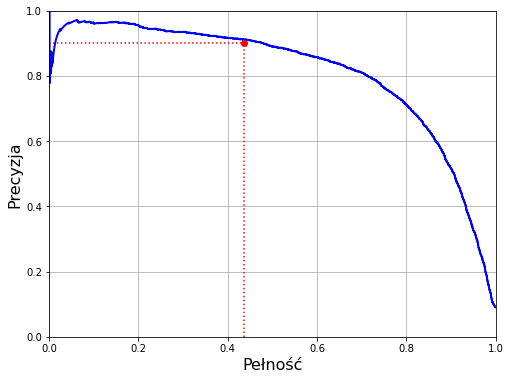

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

**Rysunek 3.5.** *Wykres precyzji w funkcji pełności*

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #~ 7816

In [32]:
threshold_90_precision

3370.0194991439557

In [33]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

### Wykres krzywej ROC
Wykres krzywej **charakterystyki roboczej odbiornika** (ang. *receiver operating characteristic* – ROC) stanowi kolejne popularne narzędzie używane wraz z klasyfikatorami binarnymi. Przypomina on w znacznym stopniu wykres precyzji w funkcji pełności, jednak w tym przypadku rysujemy **odsetek prawdziwie pozytywnych** (inna nazwa pełności; w skrócie OPP) w funkcji **odsetka fałszywie pozytywnych** (OFP) — jest to odsetek negatywnych przykładów, które zostały nieprawidłowo sklasyfi- kowane jako pozytywne. Otrzymujemy tę wartość, odejmując **odsetek prawdziwie negatywnych** (OPN) od liczby 1; jak można się domyślić, jest to odsetek negatywnych próbek, które zostały prawi- dłowo sklasyfikowane jako negatywne. Wartość ta bywa również nazywana **specyficznością**. Dlatego krzywa ROC składa się z **czułości** (czyli pełności) w funkcji **1 – specyficzność**.
Aby narysować wykres krzywej ROC, wykorzystujemy funkcję `roc_curve()` do obliczenia przykładów OPP i OFP dla różnych wartości progowych:

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

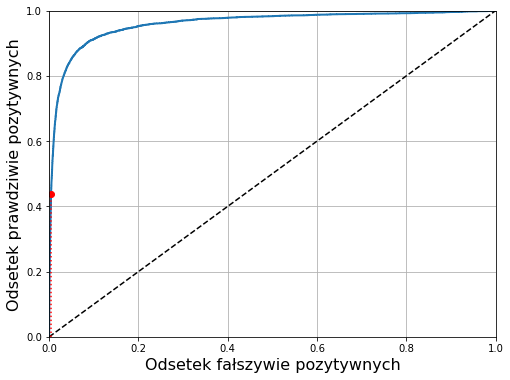

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # przerywana linia ukośna
    plt.axis([0, 1, 0, 1])                                       
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)     
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)    
    plt.grid(True)                                               

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
plt.show()

**Rysunek 3.5.** *Wykres krzywej ROC*

Jednym ze sposobów porównywania klasyfikatorów jest pomiar ich **obszaru pod krzywą** (ang. *area under the curve* — AUC). Obszar AUC w przypadku doskonałego klasyfikatora byłby równy 1, nato- miast w całkowicie losowym klasyfikatorze ma on wartość 0,5. Moduł Scikit-Learn zawiera funkcję służącą do wyliczania obszaru AUC na wykresie ROC:

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [40]:
y_scores_forest = y_probas_forest[:, 1] # wynik = prawdopodobieństwo przynależności do klasy pozytywnej
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

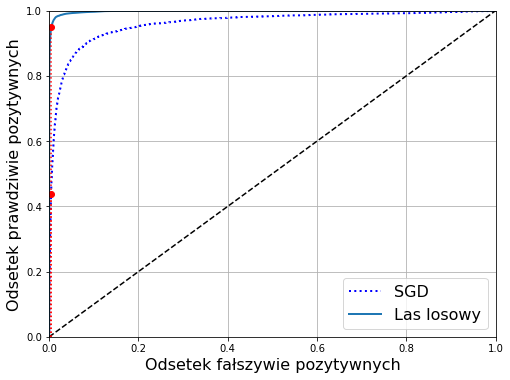

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Las losowy")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Rysunek 3.7.** *Porównanie krzywych ROC: klasyfikator lasu losowego jest lepszy od klasyfikatora SGD, ponieważ jego krzywa ROC znajduje się znacznie bliżej górnego lewego rogu, a jego obszar AUC jest także korzystniejszy*

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Spróbuj zmierzyć również wartości precyzji i pełności: powinnaś/powinieneś uzyskać wyniki rzędu, odpowiednio, 99% i 86.6% (lub wyżej).

### Wartość prezycji

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5)
precision_score(y_train_5, y_train_pred_forest)

0.9910004185851821

### Wartość pełności

In [44]:
roc_auc_score(y_train_5, y_train_pred_forest)

0.9363336166409291

***

## Klasyfikacja wieloklasowa

Klasyfikatory binarne służą do rozpoznawania dwóch klas, natomiast **klasyfikatory wieloklasowe** (zwane również **klasyfikatorami wielomianowymi**) służą do rozróżniania większej ich liczby.

Niektóre algorytmy (takie jak klasyfikatory SGD, klasyfikatory losowego lasu lub naiwne klasyfikatory bayesowskie) są w stanie natywnie zajmować się wieloma klasami naraz. Inne (takie jak maszyny wektorów nośnych czy klasyfikatory regresji logistycznej) mają charakter typowo binarny. Istnieje jednak wiele strategii, dzięki którym możemy przeprowadzać klasyfikację wieloklasową przy użyciu wielu klasyfikatorów binarnych.

Jeden ze sposobów stworzenia systemu klasyfikującego 10 klas obrazów cyfr (od 0 do 9) polega na wyuczeniu 10 klasyfikatorów binarnych, po jednym na każdą cyfrę (wykrywacz zer, jedynek, dwójek itd.). Następnie na etapie klasyfikacji obrazu uzyskujemy wynik z każdego klasyfikatora dla danej cyfry i wybieramy klasę, która uzyskała najwyższy wynik. Jest to tzw. strategia **jeden przeciw reszcie** (ang. *one-versus-rest* — OvR), znana również jako **jeden przeciw wszystkim** (ang. *one-versus-all* — OvA).

Jeszcze innym rozwiązaniem jest wyuczenie klasyfikatora binarnego dla każdej pary cyfr: jeden rozpoznaje zera i jedynki, drugi — zera i dwójki, jeszcze inny — jedynki i dwójki itd. Jest to strategia **jeden przeciw jednemu** (ang. *one-versus-one* — OvO). Jeśli masz do czynienia z N klasami, musisz wytrenować N×(N–1):2  klasyfikatorów. W przypadku zestawu danych MNIST oznacza to wyuczenie 45 klasyfikatorów binarnych! Aby zaklasyfikować dany obraz, musielibyśmy przepuścić go przez wszystkie 45 klasyfikatorów i sprawdzić, która klasa wygrywa większość „pojedynków”. Główną zaletą strategii OvO jest fakt, że każdy klasyfikator musi zostać wytrenowany jedynie wobec części zbioru uczącego składającego się z obydwu porównywanych klas.

Pewne algorytmy (jak choćby maszyny wektorów nośnych) nie skalują się zbyt dobrze do rozmiarów zbioru uczącego. W ich przypadku preferowane jest stosowanie strategii OvO, ponieważ uczenie wielu klasyfikatorów wobec niewielkich zbiorów danych przebiega szybciej niż trenowanie kilku klasyfikatorów wobec dużych zbiorów przykładów. Jednakże w przypadku większości klasyfikatorów binarnych zalecane jest korzystanie ze strategii OvR.
Moduł Scikit-Learn wykrywa sytuacje, gdy próbujemy używać algorytmu klasyfikacji binarnej w procesie klasyfikacji wieloklasowej, i automatycznie przechodzi na strategię OvR lub OvO, w zależności od algorytmu. Sprawdźmy to na klasyfikatorze maszyny wektorów nośnych (zob. rozdział 5.), za pomocą klasy `sklearn.svm.SVC`:

In [45]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

To było proste! Powyższy fragment kodu wyucza klasyfikator SVC wobec zbioru uczącego za pomocą pierwotnych klas docelowych w zakresie od 0 do 9 `(y_train)`, zatem nie korzystamy tu z klas docelowych 5 przeciw reszcie `(y_train_5)`. Następnie zostaje wyliczona prognoza (tym razem prawidłowa). Zgodnie z tą strategią moduł Scikit-Learn skorzystał w rzeczywistości ze strategii OvO: wytrenował 45 klasyfikatorów binarnych, uzyskał wyniki decyzyjne dla analizowanego obrazu i wybrał klasę, która wygrała większość „pojedynków”.

Jeżeli wywołasz metodę `decision_function()`, zauważysz, że zostaje zwrócony nie jeden wynik na obraz, ale aż 10 wyników, po jednym na każdą klasę:

In [46]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
svm_clf.classes_[5]

5

🔴🔴 Klasyfikator po wytrenowaniu przechowuje listę klas docelowych we własnym atrybucie `classes_`, w uporządkowanym szeregu kolejności. W naszym przypadku indeks każdej klasy w tablicy `classes_` dogodnie dla nas jest dopasowany do każdej klasy (np. okazuje się, że klasa o indeksie 5 symbolizuje klasę piątek), zazwyczaj jednak nie powinniśmy liczyć na takie szczęście. 🔴🔴

Jeśli chcesz zmusić moduł Scikit-Learn do stosowania strategii OvO lub OvR, możesz skorzystać z klas `OneVsOneClassifier` lub `OneVsRestClassifier`. Wystarczy stworzyć ich wystąpienie i przekazać konstruktorowi klasyfikator (nie musi być on nawet binarny). Na przykład poniższy kod stworzy klasyfikator wieloklasowy (na podstawie klasyfikatora `SVC`) przy użyciu strategii OvR:

In [50]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovr_clf.estimators_)

10

Równie łatwe jest uczenie klasyfikatora `SGDClassifier` (lub `RandomForestClassifier`):

In [52]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Tym razem nie zostały wdrożone strategie OvO ani OvR, ponieważ klasyfikatory SGD mogą bezpośrednio klasyfikować przykłady w sposób wieloklasowy. Metoda `decision_function()` zwraca teraz po jednej wartości na każdą klasę. Spójrzmy na wynik wyznaczony każdej klasie przez klasyfikator SGD:

In [53]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Jak widać, klasyfikator wykazuje dość duży stopień pewności w swoich przewidywaniach: niemal wszystkie wyniki mają dużą wartość ujemną, podczas gdy klasa 5 uzyskała wynik 2412,5. Model wykazuje drobne wątpliwości w przypadku klasy 3, której wynik to 573,5. Teraz oczywiście chcemy ocenić skuteczność tych klasyfikatorów. Jak zwykle użyjemy w tym celu sprawdzianu krzyżowego. Sprawdźmy dokładność klasyfikatora SGDClassifier za pomocą funkcji `cross_val_score()`:

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Uzyskujemy wynik 84% wobec wszystkich podzbiorów testowych. Gdybyśmy korzystali z losowego klasyfikatora, otrzymalibyśmy wynik 10% dokładności, zatem nie jest źle, ale mogłoby być znacznie lepiej. Po zwyczajnym przeskalowaniu danych wejściowych (zostało to omówione w rozdziale 2.) osiągnęlibyśmy dokładność powyżej 89%:

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

***
## Analiza Błędów
Gdybyśmy mieli do czynienia z rzeczywistym projektem, przeprowadzalibyśmy teraz czynności wy- mienione w dodatku B. Sprawdzalibyśmy możliwości przygotowywania danych, testowalibyśmy różne modele, stworzylibyśmy krótką listę najlepszych modeli i dostroilibyśmy ich hiperparametry za pomocą klasy GridSearchCV, a do tego próbowalibyśmy w jak największym stopniu zautomatyzować cały proces. Obecnie założymy, że znaleźliśmy obiecujący model, i szukamy sposobów, aby go jeszcze usprawnić. Jedną z możliwości jest analiza rodzajów błędów popełnianych przez ten model.


Po pierwsze, przyjrzyjmy się macierzy pomyłek. Podobnie jak robiliśmy to wcześniej, musimy wyliczyć prognozy za pomocą funkcji `cross_val_predict()`, a następnie wywołać funkcję `confusion_matrix()`:

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Całkiem sporo tych liczb. Często wygodniej jest spojrzeć na graficzną reprezentację macierzy pomyłek za pomocą funkcji `matshow()`:

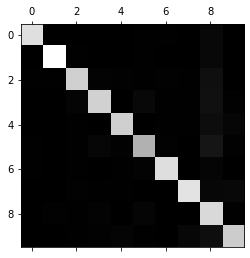

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Macierz ta wygląda całkiem nieźle, gdyż większość obrazów znajduje się na głównej przekątnej, co oznacza, że zostały prawidłowo sklasyfikowane. Piątki wyglądają nieco ciemniej od pozostałych cyfr, co może oznaczać, że w zbiorze danych znajduje się mniej obrazów piątek lub że klasyfikator nie sprawuje się tak dobrze wobec piątek, jak w przypadku pozostałych cyfr. W rzeczywistości możemy zweryfikować obydwa stwierdzenia.

Skoncentrujmy się na narysowaniu wykresu błędów. Najpierw musimy podzielić każdą wartość w macierzy pomyłek przez liczbę obrazów należących do danej klasy, dzięki czemu będziemy w stanie porównać poziomy błędu zamiast bezwzględnej liczby błędów (gdybyśmy przy niej pozostali, klasy zawierające liczne przykłady wypadałyby nazbyt niekorzystnie):

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Wypełnijmy główną przekątną zerami po to, aby pozostały same błędy, i znowu wyświetlmy macierz pomyłek w postaci graficznej:

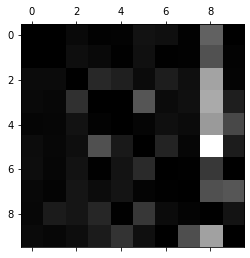

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Wyraźnie widzimy rodzaje błędów popełnianych przez klasyfikator. Przypominam, że rzędy reprezentują rzeczywiste klasy, kolumny zaś — przewidywane klasy. Kolumna reprezentująca klasę 8 jest dość jasna, co oznacza, że wiele obrazów zostało nieprawidłowo sklasyfikowanych jako ta właśnie cyfra. Jednak rząd klasy 8 nie wygląda tak źle, co oznacza, że zasadniczo większość ósemek jest prawidłowo klasyfikowanych. Jak widać, macierz pomyłek nie jest zbyt symetryczna. Możemy również dostrzec, że trójki i piątki są często mylone (w obydwie strony).

Analiza macierzy pomyłek często dostarcza wskazówek pozwalających usprawnić klasyfikator. Patrząc na nią, możemy stwierdzić, że należy popracować nad zmniejszeniem liczby fałszywych ósemek. Możesz na przykład spróbować zdobyć więcej obrazów cyfr przypominających ósemki (które jednak nimi nie są), dzięki czemu klasyfikator nauczy się je odróżniać od rzeczywistych ósemek. Ewentualnie moglibyśmy spróbować stworzyć nowe cechy pomagające klasyfikatorowi — przykładowo, napisać algorytm zliczający liczbę zamkniętych pętli na obrazie (np. cyfra 8 ma dwie pętle, szóstka ma jedną, a piątka żadnej). Jeszcze innym rozwiązaniem jest wstępne przetwarzanie obrazów (np. za pomocą modułów Scikit-Image, Pillow lub OpenCV) w taki sposób, aby uwypuklić pewne wzorce, takie jak wspomniane już zamknięte pętle.

Dzięki analizowaniu poszczególnych błędów możemy dowiedzieć się również, jak właściwie działa nasz klasyfikator i jaka jest przyczyna pomyłek, proces ten jest jednak bardziej skomplikowany i czasochłonny. Narysujmy, na przykład, wykres przykładowych trójek i piątek (funkcja `plot_digits()` wykorzystuje po prostu funkcję `imshow()` modułu Matplotlib; szczegóły znajdziesz w notatniku Jupyter dołączonym do tego rozdziału):

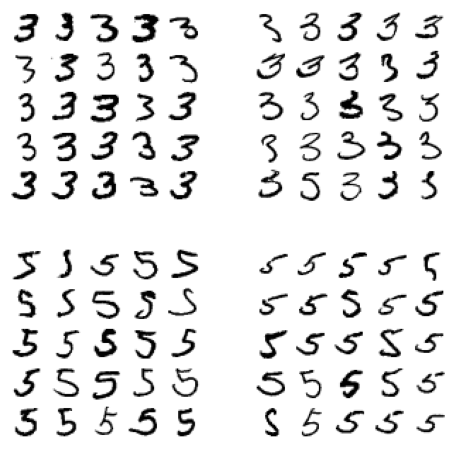

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Dwa bloki o rozmiarze 5×5 widoczne po lewej stronie przedstawiają cyfry sklasyfikowane jako trójki, natomiast po prawej stronie widzimy prognozowane piątki. Niektóre nieprawidłowo rozpoznane cyfry (np. w lewym dolnym i prawym górnym bloku) zostały tak fatalnie zapisane, że nawet człowiek miałby problem z ich klasyfikacją (np. piątka znajdująca się na przecięciu pierwszego rzędu i drugiej kolumny wygląda jak wyjątkowo niechlujnie zapisana trójka). Jednak większość nieprawidłowo sklasyfikowanych obrazów to z perspektywy ludzkiego mózgu wyraźne błędy i ciężko nam zrozumieć, dlaczego klasyfikator popełnił takie gafy. Wynika to z faktu, że skorzystaliśmy z klasy SGDClassifier, która jest w istocie prostym modelem liniowym. Przydziela on jedynie wagi przynależności do klasy dla każdego piksela, a w trakcie analizy nowej próbki po prostu sumuje ważone poziomy szarości pikseli, aby uzyskać wynik dla każdej klasy. Skoro więc trójki i piątki różnią się zaledwie kilkoma pikselami, klasyfikator może łatwo się mylić w ich rozróżnianiu.

Główną różnicą pomiędzy trójkami i piątkami jest położenie małej linii łączącej górną kreskę z dolnym łukiem. Jeśli narysujemy cyfrę '3' z tym połączeniem przesuniętym nieznacznie w lewą stronę, klasyfikator może ją uznać za '5', i odwrotnie. Innymi słowy, klasyfikator ten jest czuły na przesunięcia i obroty. Z tego wynika, że w celu ułatwienia rozróżniania trójek od piątek należałoby wstępnie przetworzyć obrazy tak, aby zostały wyśrodkowane i jak najmniej przechylone. Prawdopodobnie rozwiązanie to zmniejszyłoby występowanie również innych błędów.

## Klasyfikacja wieloetykietowa
Do tej pory każdy przykład był przydzielany wyłącznie do jednej klasy. W niektórych sytuacjach chcemy, aby klasyfikator wyznaczał wiele klas dla jednego wystąpienia. Weźmy pod uwagę klasyfikator rozpoznawania twarzy: co powinien zrobić, jeśli rozpozna kilka osób na jednym zdjęciu? Powinien przydzielić po jednej etykiecie na każdą rozpoznaną osobę. Załóżmy, że model taki został wyuczony do rozpoznawania trzech osób: Alicji, Władka i Karola. Po zaprezentowaniu zdjęć Alicji i Karola powinien zostać wygenerowany wynik [1, 0, 1] (czyli „Alicja tak, Władek nie, Karol tak”). Tego typu system klasyfikujący zdolny do wyznaczania wielu binarnych znaczników nosi nazwę systemu **klasyfikacji wieloetykietowej** (ang. *multilabel classification*).

Nie będziemy jeszcze zajmować się zagadnieniem rozpoznawania twarzy, ale przyjrzyjmy się prostszemu przykładowi, wyłącznie w celach poglądowych:

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Powyższy kod generuje tablicę `y_multilabel` zawierającą dwie docelowe etykiety dla każdego obrazu cyfry: pierwsza z nich określa, czy mamy do czynienia z cyfrą o dużej wartości (7, 8 i 9), natomiast druga mówi nam, czy dana cyfra jest nieparzysta. Następnie zostaje utworzone wystąpienie klasyfikatora `KNeighborsClassifier` (obsługuje on klasyfikację wieloetykietową, czego nie można powiedzieć o wszystkich klasyfikatorach), po czym uczymy go za pomocą tablicy zawierającej wiele docelowych elementów. Teraz możemy wyliczyć prognozy, w wyniku czego otrzymujemy dwie etykiety:

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

Zgadza się! Cyfra 5 rzeczywiście nie ma dużej wartości (`False`) i jest nieparzysta (`True`).
Istnieje wiele sposobów oceniania wydajności klasyfikatora wieloetykietowego, a dobór wskaźni- ka zależy w rzeczywistości od natury projektu. Jedną z metod jest obliczenie wyniku $F_{1}$ dla poszczególnych etykiet (lub użycie dowolnej innej omówionego wcześniej wskaźnika klasyfikatora binarnego), a następnie po prostu wyliczenie średniej. Poniższy kod wylicza uśredniony wynik $F_{1}$ dla wszystkich etykiet:

**Ostrzeżenie**: poniższa komórka może być przetwarzana przez bardzo długi czas (w zależności od sprzętu może to zająć całe godziny).

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Zakładamy tu jednak, że wszystkie etykiety mają taką samą wagę, co nie zawsze jest prawdą. Jest to istotne zwłaszcza w sytuacji, gdybyśmy mieli znacznie więcej zdjęć Alicji niż Władka lub Karola — należałoby wtedy wyznaczyć większą wagę dla wyników zdjęć Alicji. Prostym rozwiązaniem jest nada- nie każdej etykiecie wagi równej jej `współczynnikowi `wsparcia (ang. `support`; np. liczbie próbek zawierających etykietę docelową). W tym celu wystarczy w powyższym fragmencie kodu wstawić wyrażenie average="`weighted`".

***
## Klasyfikacja wielowyjściowa

Ostatnim rodzajem zadania klasyfikacyjnego, jakie omówimy, jest **klasyfikacja wielowyjściowo-wieloklasowa** (ang. *multioutput-multiclass classification*), zwana również **klasyfikacją wielowyjściową** (ang. *multioutput classification*). Jest to po prostu uogólnienie klasyfikacji wieloetykietowej, w którym każda etykieta może być wieloklasowa (tj. może mieć ponad dwie możliwe wartości).
Aby to zilustrować, stwórzmy system usuwający szumy z obrazów cyfr. Danymi wejściowymi będą zaszumione obrazy cyfr, na wyjściu natomiast uzyskamy (taką mamy nadzieję) czysty obraz cyfry w postaci tablicy zawierającej poziomy szarości poszczególnych pikseli, zupełnie jak w przypadku zestawu danych MNIST. Zwróć uwagę, że wynik klasyfikatora jest wieloetykietowy (na jeden piksel przypada jedna etykieta), a każda z etykiet może mieć różne wartości (poziomy szarości piksela mieszczą się w zakresie od 0 do 255). Jak zatem widać, jest to doskonały przykład systemu klasyfikacji wielowyjściowej.

🔵🔵 Granica pomiędzy klasyfikacją a regresją bywa czasami bardzo zamazana, tak jak w omawianym przypadku. Zapewne przewidywanie poziomu szarości pikseli bardziej przypomina regresję niż klasyfikację. Do tego systemy wielowyjściowe nie ograniczają się wyłącznie do zadań klasyfikacji; możesz nawet stworzyć system, którego rezultatami jest wiele etykiet na każdy przykład, w tym zarówno etykiety klas, jak i etykiety wartości. 🔵🔵

Zacznijmy od utworzenia zbiorów uczących i testowych — za pomocą funkcji `randint()` dołączymy zaszumienie do poziomów szarości pikseli w obrazach zbioru danych MNIST. Obrazami docelowymi będą pierwotne próbki:

In [64]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Zobaczmy, jak wygląda przykładowy obraz ze zbioru testowego (tak, zaglądamy do danych testowych, dlatego wskazany jest srogi mars na Twoim czole):

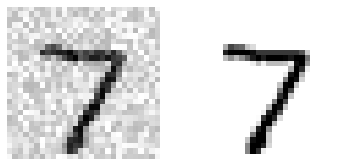

In [65]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Po lewej stronie widzimy zaszumiony obraz wejściowy, a po prawej — czysty obraz docelowy. Wyuczmy teraz nasz klasyfikator i oczyśćmy za jego pomocą obraz:

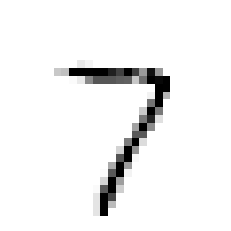

In [66]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Wygląda całkiem podobnie do obrazu docelowego! Na tym zakończymy naszą wycieczkę po krainie klasyfikacji. Umiesz już dobierać odpowiednie wskaźniki do zadań klasyfikacji, wyznaczać optymalny kompromis pomiędzy precyzją a pełnością, porównywać klasyfikatory, a także — bardziej ogólnie — tworzyć dobre systemy klasyfikujące dopasowane do różnorodnych zadań.

In [67]:
import pip

In [68]:
!pip list

Package                            Version
---------------------------------- ----------------------
absl-py                            0.10.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.9.12
anaconda-project                   0.8.3
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.0
appscript                          1.1.1
argh                               0.26.2
asn1crypto                         1.3.0
astor                              0.8.1
astroid                            2.4.2
astropy                            4.0.1.post1
astunparse                         1.6.3
atomicwrites                       1.4.0
attrs                              19.3.0
autopep8                           1.5.3
Babel                              2.8.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-termin